In [1]:
import numpy as np
from scipy import sparse
from scipy.linalg import cholesky, solve_triangular
from scipy.io import loadmat
import time
import matplotlib.pyplot as plt

In [2]:
def cov_matern(d, loghyper, x):
    ell = np.exp(loghyper[0])
    sf2 = np.exp(2 * loghyper[1])    
    def f(t):
        if d == 1: return 1
        if d == 3: return 1 + t
        if d == 5: return 1 + t * (1 + t / 3)
        if d == 7: return 1 + t * (1 + t * (6 + t) / 15)       
    def m(t):
        return f(t) * np.exp(-t)   
    dist_sq = ((x[:, None] - x[None, :]) / ell) ** 2
    return sf2 * m(np.sqrt(d * dist_sq))

def RL_precision(logbeta, A):
    beta = np.exp(logbeta)    
    A = np.asarray(A, dtype=float)
    n = A.shape[0]
    A = A - np.eye(n)
    iD = np.diag(1 / np.sqrt(A.sum(axis=0))) 
    Lap = np.eye(n) - iD @ A @ iD    
    return np.eye(n) + beta * Lap

In [3]:
def compute_factor_term(G, mask, Y, dim):
    Psi = sparse.kron(G, sparse.eye(dim, format="csr"), format="csr")
    mask_vec = (np.asarray(mask).ravel(order="F") == 1)
    rows = np.flatnonzero(mask_vec)
    Psi_mask = Psi[rows, :]
    HH = Psi_mask.T @ Psi_mask
    y_obs = np.asarray(Y).ravel(order="F")[mask_vec].reshape(-1, 1)
    Hy = Psi_mask.T @ y_obs
    return HH, Hy

def compute_likeli_term(invK, R, tau, HH, Hy):
    invSigma = sparse.kron(sparse.eye(R, format="csr"), invK, format="csr")
    Lambda = (tau * HH + invSigma).toarray()
    cholL = cholesky(Lambda)
    uu = solve_triangular(cholL.T, Hy, lower=True)
    likeli_temp = 0.5 * (tau ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholL)))
    return invSigma, cholL, likeli_temp

def compute_likeli_KU(tau, invKu, HHU, HyU, R):
    invKU, cholLU, likeli_temp = compute_likeli_term(invKu, R, tau, HHU, HyU)
    cholLu = cholesky(invKu)
    likeli_KU = likeli_temp + R * np.sum(np.log(np.diag(cholLu)))
    return cholLu, invKU, cholLU, likeli_KU

def compute_likeli_KV(tau, Kv, HHV, HyV, R):
    eigvalKv, Qvt = np.linalg.eigh(Kv)
    invKv = Qvt @ np.diag(1.0 / eigvalKv) @ Qvt.T
    invKV, cholLV, likeli_temp = compute_likeli_term(invKv, R, tau, HHV, HyV)
    likeli_KV = likeli_temp + 0.5 * R * np.sum(np.log(eigvalKv))
    return eigvalKv, invKV, cholLV, likeli_KV

def prior_theta(hpri, theta):
    mu, lamb = hpri
    return -0.5 * lamb * (theta-mu) ** 2

def theta_range(ranges, theta, min_hp, max_hp):
    tempt = ranges * np.random.rand()
    tmin = max(theta - tempt, min_hp)
    tmax = min(tmin + ranges, max_hp)
    return tmin, tmax

def hyperU_RL_marginal(theta_est, ranges, likeli, tau, HHU, HyU, min_hp, max_hp, hpri, A, R):
    PU = likeli + prior_theta(hpri, theta_est)  
    tmin, tmax = theta_range(ranges, theta_est, min_hp, max_hp)
    logu = np.log(np.random.rand())
    while True:
        theta_next = tmin + (tmax - tmin) * np.random.rand()
        invKu_next = RL_precision(theta_next, A)        
        cholLu, invKU_next, cholLU, likeli_next = compute_likeli_KU(tau, invKu_next, HHU, HyU, R)
        PU_next = likeli_next + prior_theta(hpri, theta_next)
        if PU_next - PU > logu:
            return theta_next, invKU_next, cholLU, cholLu, likeli_next
        elif theta_next < theta_est:
            tmin = theta_next
        else:
            tmax = theta_next

def hyperV_Matern_marginal(theta_est, ranges, likeli, tau, HHV, HyV, min_hp, max_hp, hpri, d_Matern, matern_var, T, R):    
    PV = likeli + prior_theta(hpri, theta_est)
    tmin, tmax = theta_range(ranges, theta_est, min_hp, max_hp)
    logu = np.log(np.random.rand())
    while True:
        theta_next = tmin + (tmax - tmin) * np.random.rand()
        Kv_next = cov_matern(d_Matern, [theta_next, np.log(matern_var)], np.arange(1, T + 1))
        eigvalKv, invKV_next, cholLV, likeli_next = compute_likeli_KV(tau, Kv_next, HHV, HyV, R)
        PV_next = likeli_next + prior_theta(hpri, theta_next)
        if PV_next - PV > logu:
            return theta_next, invKV_next, cholLV, eigvalKv, likeli_next
        elif theta_next < theta_est:
            tmin = theta_next
        else:
            tmax = theta_next

In [4]:
def mvnrnd_pre_ch(mean, chol_prec):
    z = np.random.randn(mean.shape[0], 1)
    return mean + solve_triangular(chol_prec, z, lower=False)

def sample_factor(tau, cholL, Hy, N):
    tmp = solve_triangular(cholL.T, Hy, lower=True)
    Mean = tau * solve_triangular(cholL, tmp, lower=False)
    temp_vec = mvnrnd_pre_ch(Mean, cholL)
    return temp_vec.reshape((N[0], N[1]), order="F")

In [5]:
def sample_tau(Y, Y_est, mask_matrix, num_obser, a0, b0):
    Err = np.linalg.norm((Y - Y_est) * mask_matrix, ord='fro')**2
    a_tau = a0 + 0.5 * num_obser
    b_tau = b0 + 0.5 * Err
    return np.random.gamma(shape=a_tau, scale=1.0 / b_tau)

In [6]:
def compute_mae(Y, Y_est, mask_test):
    return np.sum(np.abs(Y_est - Y) * mask_test) / np.sum(mask_test)

def compute_rmse(Y, Y_est, mask_test):
    return np.sqrt((np.linalg.norm((Y - Y_est) * mask_test, ord="fro")**2) / np.sum(mask_test == 1))

In [7]:
def BKMF(I, Omega, mask_test, U_gra_scale, V_matern_scale, V_matern_var, ranges, min_hp, max_hp, hpri, A, d_Matern, a0, b0, R, burn_iter, pos_iter, start):
    N = np.array(I.shape)
    D = I.ndim
    num_obser = np.sum(Omega)
    mask_matrix = [Omega, Omega.T]
    
    train_matrix = I * Omega
    train_matrix = train_matrix[train_matrix > 0]
    Isubmean = I - np.mean(train_matrix)
    I_train = Isubmean * Omega
    Y_train = [I_train, I_train.T]
    
    G = [0.1 * np.random.randn(N[d], R) for d in range(D)]
    
    max_iter = burn_iter + pos_iter
    mae = np.zeros(max_iter)
    rmse = np.zeros(max_iter)
    G_save = [np.zeros((N[d], R, pos_iter)) for d in range(D)]
    hyper_K = np.zeros((max_iter + 1, D))
    
    hyper_K[0, 0] = np.log(U_gra_scale)
    hyper_K[0, 1] = np.log(V_matern_scale)
    invKu = RL_precision(hyper_K[0, 0], A)
    Kv = cov_matern(d_Matern, [hyper_K[0, 1], np.log(V_matern_var)], np.arange(1, N[1] + 1))
    
    HH = [None] * D
    Hy = [None] * D
    for d in range(D):
        HH[d], Hy[d] = compute_factor_term(G[1-d], mask_matrix[d], Y_train[d], N[d])
    
    tau = np.zeros(max_iter + 1)
    tau[0] = 1e-2
    cholLu, invKU, cholLU, likeli_KU = compute_likeli_KU(tau[0], invKu, HH[0], Hy[0], R)
    eigvalKv, invKV, cholLV, likeli_KV = compute_likeli_KV(tau[0], Kv, HH[1], Hy[1], R)
    
    Y_est_sum = 0
    Y_est_sum2 = 0
    for it in range(burn_iter + pos_iter):
        hyper_K[it+1, 0], invKU, cholLU, cholLu, likeli_KU = hyperU_RL_marginal(
            hyper_K[it, 0], ranges[0], likeli_KU, tau[it], HH[0], Hy[0], min_hp[0], max_hp[0], hpri[0], A, R)
        
        G[0] = sample_factor(tau[it], cholLU, Hy[0], G[0].shape)

        hyper_K[it+1, 1], invKV, cholLV, eigvalKv, likeli_KV = hyperV_Matern_marginal(
            hyper_K[it, 1], ranges[1], likeli_KV, tau[it], HH[1], Hy[1], min_hp[1], max_hp[1], hpri[1], d_Matern, V_matern_var, N[1], R)
        
        HH[1], Hy[1] = compute_factor_term(G[0], mask_matrix[1], Y_train[1], N[1])
        LambdaV = (tau[it] * HH[1] + invKV).toarray()
        cholLV = cholesky(LambdaV)
        G[1] = sample_factor(tau[it], cholLV, Hy[1], G[1].shape)
        
        Y_est = G[0] @ G[1].T
        
        tau[it + 1] = sample_tau(Isubmean, Y_est, mask_matrix[0], num_obser, a0, b0)
        
        if it >= burn_iter:
            st_it = it - burn_iter
            for d in range(D):
                G_save[d][:, :, st_it] = G[d]
            Y_est_sum2 = Y_est_sum2 + Y_est
        
        Y_est_sum = Y_est_sum + Y_est
        Y_est_ave = Y_est_sum/(it + 1)
        
        mae[it] = compute_mae(Isubmean, Y_est_ave, mask_test)
        rmse[it] = compute_rmse(Isubmean, Y_est_ave, mask_test)
        
        print(f"Epoch = {it + 1}, tau = {tau[it + 1]}, mae = {mae[it]}, rmse = {rmse[it]}")
        end = time.time()
        print('Running time: %d seconds'%(end - start))
        
        HH[0], Hy[0] = compute_factor_term(G[1], mask_matrix[0], Y_train[0], N[0])
        LambdaU = (tau[it + 1] * HH[0] + invKU).toarray()
        cholLU = cholesky(LambdaU)
        uu = solve_triangular(cholLU.T, Hy[0], lower=True)
        likeli_KU = 0.5 * (tau[it + 1] ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholLU))) + R * np.sum(np.log(np.diag(cholLu)))
        
        LambdaV = (tau[it + 1] * HH[1] + invKV).toarray()
        cholLV = cholesky(LambdaV)
        uu = solve_triangular(cholLV.T, Hy[1], lower=True)
        likeli_KV = 0.5 * (tau[it + 1] ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholLV))) + 0.5 * R * np.sum(np.log(eigvalKv))
        
    return G, G_save, hyper_K, tau, mae, rmse, Y_est_sum2/pos_iter + np.mean(train_matrix)

In [8]:
seedr = 6
np.random.seed(seedr)
A = loadmat('../data/traffic/seattle/seattle_adj.mat')['A']
I = loadmat('../data/traffic/seattle/sedata_amonth_matrix.mat')['data_matrix']
N = I.shape
Omega_raw = (I != 0).astype(np.int8)

missing_rate = 0.5 # Random missing (RM)
mask_matrix = (np.round(np.random.rand(N[0], N[1]) + 0.5 - missing_rate)).astype(np.int8)
mask_matrix = mask_matrix & Omega_raw
mask_test = (1 - mask_matrix) & Omega_raw

U_gra_scale = 1
V_matern_scale = 1
V_matern_var = 1
ranges = [np.log(10), np.log(10)]
min_hp = [np.log(1e-3), np.log(1e-6)]
max_hp = [np.log(1e3), np.log(1e6)]
hpri = [None] * 2
hpri[0] = [np.log(10), 1]
hpri[1] = [np.log(10), 1]
d_Matern = 3
a0 = 1e-6
b0 = 1e-6
R = 10
burn_iter = 600
pos_iter = 400

start = time.time()
G, G_save, hyper_K, tau, mae, rmse, Y_est_ = BKMF(
    I, mask_matrix, mask_test, U_gra_scale, V_matern_scale, V_matern_var, ranges, min_hp, max_hp, hpri, A, d_Matern, a0, b0, R, burn_iter, pos_iter, start)

Epoch = 1, tau = 0.009435092208665324, mae = 6.958165869307865, rmse = 10.532178348664454
Running time: 7 seconds
Epoch = 2, tau = 0.03697253450907345, mae = 4.724518048734913, rmse = 7.233102672437235
Running time: 14 seconds
Epoch = 3, tau = 0.061238137667688874, mae = 3.7642993441999115, rmse = 5.862934917888954
Running time: 28 seconds
Epoch = 4, tau = 0.07854780648205008, mae = 3.233695847292867, rmse = 5.131752695502853
Running time: 37 seconds
Epoch = 5, tau = 0.08411316643301457, mae = 2.9249727707802995, rmse = 4.715249992726064
Running time: 51 seconds
Epoch = 6, tau = 0.08495959491465052, mae = 2.7331392112190556, rmse = 4.463992360694567
Running time: 84 seconds
Epoch = 7, tau = 0.0855226961983531, mae = 2.6067114516991565, rmse = 4.3021346015698585
Running time: 109 seconds
Epoch = 8, tau = 0.08597812015538112, mae = 2.519494113607131, rmse = 4.1923807575375855
Running time: 135 seconds
Epoch = 9, tau = 0.08596585525205773, mae = 2.456730924097143, rmse = 4.114901626909559

Epoch = 72, tau = 0.08648852857815527, mae = 2.212657715419707, rmse = 3.822945602324102
Running time: 1585 seconds
Epoch = 73, tau = 0.087069799632284, mae = 2.2126162231579682, rmse = 3.8228504976748297
Running time: 1607 seconds
Epoch = 74, tau = 0.08708135480048751, mae = 2.2125369208516408, rmse = 3.822811029197668
Running time: 1631 seconds
Epoch = 75, tau = 0.08661295677691308, mae = 2.212477521039633, rmse = 3.8229087671675916
Running time: 1648 seconds
Epoch = 76, tau = 0.08711384792782809, mae = 2.212512261769259, rmse = 3.822943339152316
Running time: 1672 seconds
Epoch = 77, tau = 0.08669470595158807, mae = 2.21260528043285, rmse = 3.823051261453658
Running time: 1711 seconds
Epoch = 78, tau = 0.0860543847605796, mae = 2.2125764635816316, rmse = 3.8229907725876275
Running time: 1723 seconds
Epoch = 79, tau = 0.08638469491376363, mae = 2.2126036050114553, rmse = 3.8230657024386763
Running time: 1751 seconds
Epoch = 80, tau = 0.08672839745583781, mae = 2.2126782491758266, rms

Epoch = 142, tau = 0.08713280380669314, mae = 2.2139716652595482, rmse = 3.8264489296785453
Running time: 3199 seconds
Epoch = 143, tau = 0.08642468947732475, mae = 2.2139789809893253, rmse = 3.8265251346680635
Running time: 3219 seconds
Epoch = 144, tau = 0.08662890941091854, mae = 2.2140148926682164, rmse = 3.826544914995579
Running time: 3246 seconds
Epoch = 145, tau = 0.08706644473862057, mae = 2.2140381309962414, rmse = 3.826616549776602
Running time: 3276 seconds
Epoch = 146, tau = 0.08686044108487335, mae = 2.21402093597221, rmse = 3.8266750155679436
Running time: 3298 seconds
Epoch = 147, tau = 0.08620419913661215, mae = 2.214039909491714, rmse = 3.8267107607241515
Running time: 3319 seconds
Epoch = 148, tau = 0.08636369694810991, mae = 2.2140613115539423, rmse = 3.826757208805473
Running time: 3333 seconds
Epoch = 149, tau = 0.08667525405294144, mae = 2.2140144107306265, rmse = 3.8267336338940563
Running time: 3359 seconds
Epoch = 150, tau = 0.08692340497476028, mae = 2.214041

Epoch = 212, tau = 0.08648196849947638, mae = 2.2154057202272694, rmse = 3.828685862900829
Running time: 4616 seconds
Epoch = 213, tau = 0.08556269233048633, mae = 2.2154529335870383, rmse = 3.8287159374621975
Running time: 4647 seconds
Epoch = 214, tau = 0.08695361600010561, mae = 2.2154764131647533, rmse = 3.8287612231740797
Running time: 4669 seconds
Epoch = 215, tau = 0.08657557667995737, mae = 2.2154948084713495, rmse = 3.828807231065459
Running time: 4689 seconds
Epoch = 216, tau = 0.08687835266378338, mae = 2.2155023005520165, rmse = 3.82887009836002
Running time: 4722 seconds
Epoch = 217, tau = 0.08738883274504367, mae = 2.2154794976802084, rmse = 3.8288316037000607
Running time: 4743 seconds
Epoch = 218, tau = 0.08724046203220776, mae = 2.215504476949845, rmse = 3.8288244761854293
Running time: 4768 seconds
Epoch = 219, tau = 0.08714082289395056, mae = 2.2154833198876647, rmse = 3.8288216288572867
Running time: 4781 seconds
Epoch = 220, tau = 0.08602833118828478, mae = 2.21549

Epoch = 282, tau = 0.08758520958822763, mae = 2.2159036820637534, rmse = 3.829749631297718
Running time: 6267 seconds
Epoch = 283, tau = 0.08674163840376148, mae = 2.215908333304874, rmse = 3.8297471166704016
Running time: 6277 seconds
Epoch = 284, tau = 0.0874928806413035, mae = 2.215883590744618, rmse = 3.8297350584447387
Running time: 6297 seconds
Epoch = 285, tau = 0.08640957214025971, mae = 2.215901711245968, rmse = 3.829789679389391
Running time: 6319 seconds
Epoch = 286, tau = 0.08743069891969427, mae = 2.2159147234924315, rmse = 3.829799109520055
Running time: 6339 seconds
Epoch = 287, tau = 0.08709431879730435, mae = 2.215920431427811, rmse = 3.8298027321019874
Running time: 6368 seconds
Epoch = 288, tau = 0.08662719198653562, mae = 2.2159373116830476, rmse = 3.829840631815407
Running time: 6392 seconds
Epoch = 289, tau = 0.08637905457130086, mae = 2.2159295948085065, rmse = 3.8298584825128836
Running time: 6416 seconds
Epoch = 290, tau = 0.08705299436918282, mae = 2.215926967

Epoch = 352, tau = 0.08658108084320086, mae = 2.2163851829159995, rmse = 3.8306204536195403
Running time: 7761 seconds
Epoch = 353, tau = 0.08677057740367139, mae = 2.216364829038588, rmse = 3.8306340924458797
Running time: 7779 seconds
Epoch = 354, tau = 0.0872952886057043, mae = 2.2163673786071403, rmse = 3.8306431158644467
Running time: 7793 seconds
Epoch = 355, tau = 0.08662204444690606, mae = 2.216359062515983, rmse = 3.83063763228635
Running time: 7815 seconds
Epoch = 356, tau = 0.08670954569820083, mae = 2.2163638745034966, rmse = 3.830624817917139
Running time: 7846 seconds
Epoch = 357, tau = 0.08716003462860168, mae = 2.2163873626365866, rmse = 3.8306243123885233
Running time: 7873 seconds
Epoch = 358, tau = 0.08590866721068155, mae = 2.2163799982853067, rmse = 3.8306282749788565
Running time: 7892 seconds
Epoch = 359, tau = 0.08682484973464562, mae = 2.2163667354362713, rmse = 3.8306504933470316
Running time: 7910 seconds
Epoch = 360, tau = 0.08662890191187964, mae = 2.216365

Epoch = 422, tau = 0.08692728916302511, mae = 2.2170346458790275, rmse = 3.8317166369113558
Running time: 10739 seconds
Epoch = 423, tau = 0.08711173340942312, mae = 2.2170457703034945, rmse = 3.831730086669409
Running time: 10789 seconds
Epoch = 424, tau = 0.08639168961230582, mae = 2.2170401228211745, rmse = 3.8317373938470087
Running time: 10885 seconds
Epoch = 425, tau = 0.08652848734305985, mae = 2.2170300722757457, rmse = 3.8317304219084853
Running time: 10922 seconds
Epoch = 426, tau = 0.08636902634138745, mae = 2.2170463020318794, rmse = 3.8317548163755157
Running time: 10958 seconds
Epoch = 427, tau = 0.08676546691187573, mae = 2.2170570018491094, rmse = 3.831784495865527
Running time: 11032 seconds
Epoch = 428, tau = 0.08745259117638593, mae = 2.217081246673911, rmse = 3.831798532391838
Running time: 11094 seconds
Epoch = 429, tau = 0.08683905804408289, mae = 2.2170918526926915, rmse = 3.831819592330273
Running time: 11171 seconds
Epoch = 430, tau = 0.08628825467029154, mae =

Epoch = 491, tau = 0.08712324503997486, mae = 2.217363983713907, rmse = 3.8322000546808144
Running time: 14721 seconds
Epoch = 492, tau = 0.08622177855257451, mae = 2.2173680259199506, rmse = 3.832213640358642
Running time: 14757 seconds
Epoch = 493, tau = 0.08688920625761058, mae = 2.2173593387618973, rmse = 3.8322099636858398
Running time: 14812 seconds
Epoch = 494, tau = 0.086958673042445, mae = 2.2173540003847476, rmse = 3.8322056339802155
Running time: 14866 seconds
Epoch = 495, tau = 0.08653354625152944, mae = 2.2173668090166996, rmse = 3.8322101786794596
Running time: 14902 seconds
Epoch = 496, tau = 0.0870172384784682, mae = 2.217373239481787, rmse = 3.8321982913191737
Running time: 14924 seconds
Epoch = 497, tau = 0.08632569933324553, mae = 2.217386200379873, rmse = 3.8322043833295774
Running time: 15008 seconds
Epoch = 498, tau = 0.08653495863369594, mae = 2.2174003560804008, rmse = 3.8322140546840386
Running time: 15039 seconds
Epoch = 499, tau = 0.0870259842332091, mae = 2.

Epoch = 560, tau = 0.08723795917204573, mae = 2.217830358011057, rmse = 3.8326805158551953
Running time: 19012 seconds
Epoch = 561, tau = 0.0871316610257928, mae = 2.217837798963036, rmse = 3.8326827772951853
Running time: 19042 seconds
Epoch = 562, tau = 0.08650261288781631, mae = 2.217840962854076, rmse = 3.832688364739995
Running time: 19072 seconds
Epoch = 563, tau = 0.08698937308283207, mae = 2.2178496255584106, rmse = 3.8326897444168053
Running time: 19104 seconds
Epoch = 564, tau = 0.08666559128721654, mae = 2.217858222858237, rmse = 3.832707833128394
Running time: 19142 seconds
Epoch = 565, tau = 0.08652533432725182, mae = 2.217879206219945, rmse = 3.832729446297167
Running time: 19213 seconds
Epoch = 566, tau = 0.08670865354416438, mae = 2.217886742096399, rmse = 3.8327266163034874
Running time: 19284 seconds
Epoch = 567, tau = 0.0864781101302321, mae = 2.2178880992853705, rmse = 3.832744677885689
Running time: 19359 seconds
Epoch = 568, tau = 0.08694934675239183, mae = 2.2178

Epoch = 630, tau = 0.08645390570427822, mae = 2.218117988163553, rmse = 3.833220867287941
Running time: 22911 seconds
Epoch = 631, tau = 0.08686219299864426, mae = 2.2181265012955445, rmse = 3.8332377482323454
Running time: 23012 seconds
Epoch = 632, tau = 0.08687835075434457, mae = 2.218129530359769, rmse = 3.8332459445467637
Running time: 23062 seconds
Epoch = 633, tau = 0.08668944194274619, mae = 2.2181363915404084, rmse = 3.8332533623443985
Running time: 23109 seconds
Epoch = 634, tau = 0.08635430522960955, mae = 2.2181389645797553, rmse = 3.833268570378644
Running time: 23169 seconds
Epoch = 635, tau = 0.08658385659666933, mae = 2.2181400747003206, rmse = 3.8332589655531253
Running time: 23230 seconds
Epoch = 636, tau = 0.0865710145917968, mae = 2.2181376005531708, rmse = 3.833251913220036
Running time: 23292 seconds
Epoch = 637, tau = 0.08658860726189482, mae = 2.2181194604806826, rmse = 3.8332195418009
Running time: 23327 seconds
Epoch = 638, tau = 0.08647147121800149, mae = 2.2

Epoch = 700, tau = 0.08752485834136449, mae = 2.2183152750317268, rmse = 3.8333576548233785
Running time: 27006 seconds
Epoch = 701, tau = 0.0868953361171558, mae = 2.2183222071743214, rmse = 3.833373909939037
Running time: 27088 seconds
Epoch = 702, tau = 0.08665205565601783, mae = 2.2183362389809074, rmse = 3.8333820231213136
Running time: 27163 seconds
Epoch = 703, tau = 0.0866262701199067, mae = 2.218341129242948, rmse = 3.8333768926276055
Running time: 27207 seconds
Epoch = 704, tau = 0.08584500077759977, mae = 2.2183423915988145, rmse = 3.8333750349130815
Running time: 27266 seconds
Epoch = 705, tau = 0.08706978172901644, mae = 2.2183462058395174, rmse = 3.8333780504339834
Running time: 27323 seconds
Epoch = 706, tau = 0.08673426551603057, mae = 2.218341075552729, rmse = 3.833378584195923
Running time: 27401 seconds
Epoch = 707, tau = 0.08689634922110814, mae = 2.218333189014167, rmse = 3.8333670202037973
Running time: 27486 seconds
Epoch = 708, tau = 0.08707706496359853, mae = 2

Epoch = 769, tau = 0.08724630995164454, mae = 2.2183785801729217, rmse = 3.8334847924867304
Running time: 31112 seconds
Epoch = 770, tau = 0.0863804331051645, mae = 2.218399613523093, rmse = 3.833508370955137
Running time: 31179 seconds
Epoch = 771, tau = 0.08681550869745898, mae = 2.2184066621816743, rmse = 3.833511935397598
Running time: 31214 seconds
Epoch = 772, tau = 0.08754023541133277, mae = 2.2184073304410856, rmse = 3.83352659909153
Running time: 31299 seconds
Epoch = 773, tau = 0.08718990956752555, mae = 2.2184126293873345, rmse = 3.833523719868353
Running time: 31360 seconds
Epoch = 774, tau = 0.08681053730040621, mae = 2.218413383845543, rmse = 3.8335241841821404
Running time: 31406 seconds
Epoch = 775, tau = 0.08665481222014898, mae = 2.218408181029487, rmse = 3.8335162197180694
Running time: 31467 seconds
Epoch = 776, tau = 0.08620588917527815, mae = 2.2184110586014234, rmse = 3.8335066477253803
Running time: 31538 seconds
Epoch = 777, tau = 0.08662740791569234, mae = 2.2

Epoch = 838, tau = 0.08647749348519902, mae = 2.218372376563372, rmse = 3.833683751094838
Running time: 35175 seconds
Epoch = 839, tau = 0.08659506805510413, mae = 2.2183704206059667, rmse = 3.8336801495006876
Running time: 35264 seconds
Epoch = 840, tau = 0.08641039787312936, mae = 2.2183660857119536, rmse = 3.83367207845478
Running time: 35327 seconds
Epoch = 841, tau = 0.08702442629197184, mae = 2.2183713150805153, rmse = 3.833670366765338
Running time: 35398 seconds
Epoch = 842, tau = 0.08694986296181063, mae = 2.218375573474494, rmse = 3.8336769202646237
Running time: 35448 seconds
Epoch = 843, tau = 0.08743712318883655, mae = 2.2183839515271764, rmse = 3.833683266879195
Running time: 35496 seconds
Epoch = 844, tau = 0.08642154682169266, mae = 2.2183802027511685, rmse = 3.8336855874778726
Running time: 35584 seconds
Epoch = 845, tau = 0.08735921473325009, mae = 2.2183732589881777, rmse = 3.8336740031962813
Running time: 35609 seconds
Epoch = 846, tau = 0.08684578890200431, mae = 2

Epoch = 907, tau = 0.0868548999632159, mae = 2.2186156821161003, rmse = 3.833804173515514
Running time: 39275 seconds
Epoch = 908, tau = 0.08617133647215486, mae = 2.2186216573812896, rmse = 3.8338194920589843
Running time: 39336 seconds
Epoch = 909, tau = 0.08638362248534628, mae = 2.2186135043679056, rmse = 3.8338226445102808
Running time: 39369 seconds
Epoch = 910, tau = 0.08683927072401032, mae = 2.2186143442298896, rmse = 3.8338226713255397
Running time: 39427 seconds
Epoch = 911, tau = 0.08639434911860301, mae = 2.2186188142663728, rmse = 3.833823119846281
Running time: 39480 seconds
Epoch = 912, tau = 0.08682674710369657, mae = 2.2186214943279534, rmse = 3.8338310308012935
Running time: 39495 seconds
Epoch = 913, tau = 0.08649339869868773, mae = 2.2186223318366984, rmse = 3.83383186767703
Running time: 39547 seconds
Epoch = 914, tau = 0.08724927398063617, mae = 2.2186321019105493, rmse = 3.8338455894853656
Running time: 39623 seconds
Epoch = 915, tau = 0.08677866677850243, mae =

Epoch = 976, tau = 0.08660581412366467, mae = 2.218696325533388, rmse = 3.8338963252736367
Running time: 42627 seconds
Epoch = 977, tau = 0.08740550160196829, mae = 2.218696772397875, rmse = 3.8338990526884857
Running time: 42671 seconds
Epoch = 978, tau = 0.08690892172927529, mae = 2.218693675593385, rmse = 3.8338946544456958
Running time: 42701 seconds
Epoch = 979, tau = 0.08658594522429901, mae = 2.218687511197911, rmse = 3.8338907700480354
Running time: 42734 seconds
Epoch = 980, tau = 0.08626346397378917, mae = 2.218682124080785, rmse = 3.833892264068815
Running time: 42769 seconds
Epoch = 981, tau = 0.08639260936225927, mae = 2.2186797233006628, rmse = 3.8338877861751257
Running time: 42814 seconds
Epoch = 982, tau = 0.08714293566176351, mae = 2.2186837386877043, rmse = 3.833891528456244
Running time: 42861 seconds
Epoch = 983, tau = 0.08641587043485215, mae = 2.2186834514819203, rmse = 3.833880865169541
Running time: 42892 seconds
Epoch = 984, tau = 0.0872774891611061, mae = 2.2

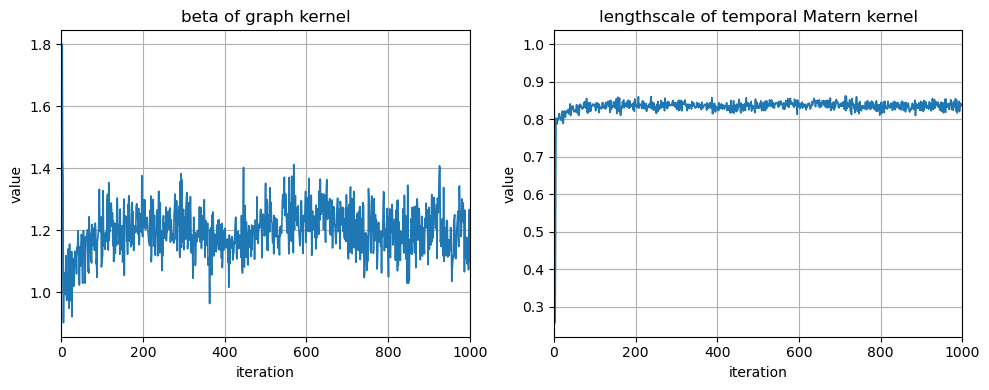

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

axes[0].plot(np.exp(hyper_K[:, 0]), linewidth=1.2)
axes[0].set_title("beta of graph kernel")
axes[0].grid(True)
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("value")
axes[0].set_xlim(0, len(hyper_K[:, 0]) - 1)

axes[1].plot(np.exp(hyper_K[:, 1]), linewidth=1.2)
axes[1].set_title("lengthscale of temporal Matern kernel")
axes[1].grid(True)
axes[1].set_xlabel("iteration")
axes[1].set_ylabel("value")
axes[1].set_xlim(0, len(hyper_K[:, 1]) - 1)

plt.show()

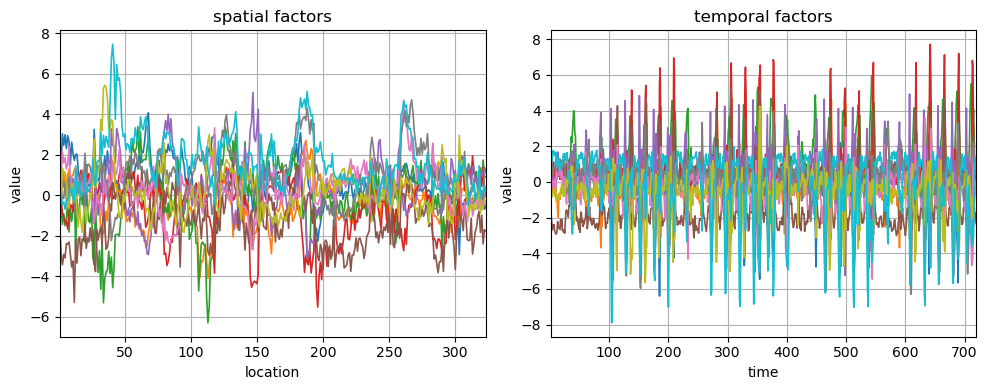

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
x = np.arange(1, N[0] + 1)
axes[0].plot(x, G[0], linewidth=1.2)
axes[0].set_title("spatial factors")
axes[0].grid(True)
axes[0].set_xlabel("location")
axes[0].set_ylabel("value")
axes[0].set_xlim(1, len(x))

x = np.arange(1, N[1] + 1)
axes[1].plot(x, G[1], linewidth=1.2)
axes[1].set_title("temporal factors")
axes[1].grid(True)
axes[1].set_xlabel("time")
axes[1].set_ylabel("value")
axes[1].set_xlim(1, len(x))

plt.show()

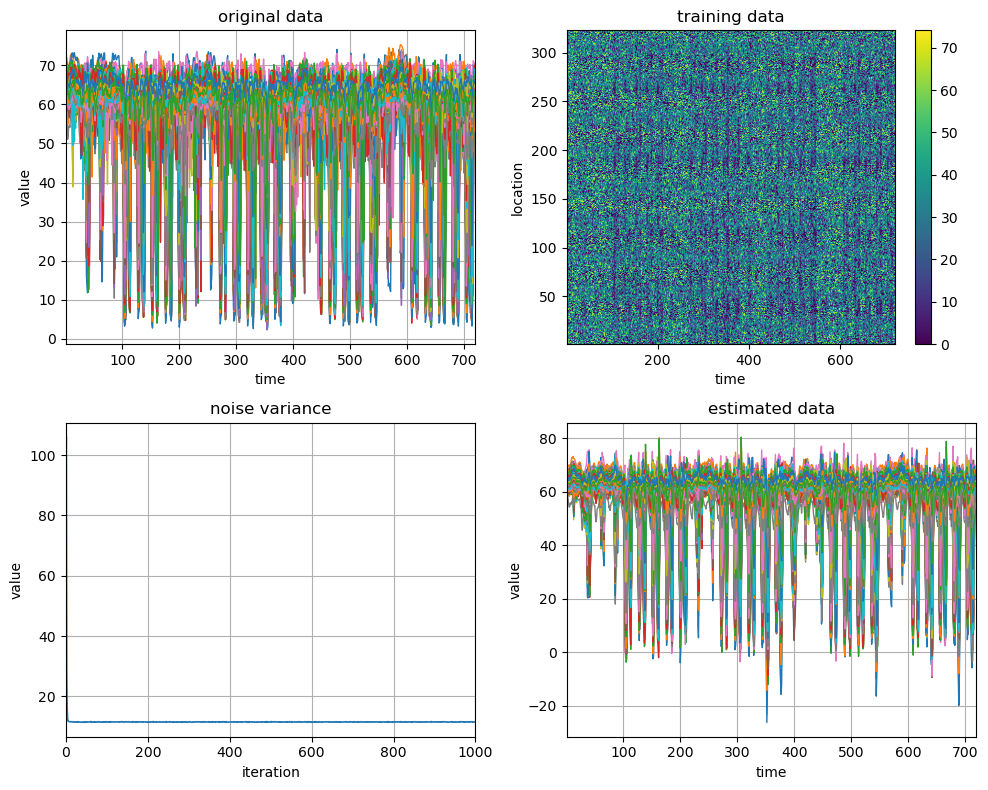

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)

x = np.arange(1, N[1] + 1)
axes[0,0].plot(x, I.T, linewidth=1)
axes[0,0].set_title("original data")
axes[0,0].grid(True)
axes[0,0].set_xlabel("time")
axes[0,0].set_ylabel("value")
axes[0,0].set_xlim(1, len(x))

im = axes[0,1].imshow(I * mask_matrix, aspect="auto", origin="lower", extent=[1,N[1], 1,N[0]])
axes[0,1].set_title("training data")
axes[0,1].set_xlabel("time")
axes[0,1].set_ylabel("location")
fig.colorbar(im, ax=axes[0,1])

axes[1,0].plot(1.0 / tau, linewidth=1.2)
axes[1,0].set_title("noise variance")
axes[1,0].grid(True)
axes[1,0].set_xlabel("iteration")
axes[1,0].set_ylabel("value")
axes[1,0].set_xlim(0, len(tau) - 1)

axes[1,1].plot(x, Y_est_.T, linewidth=1)
axes[1,1].set_title("estimated data")
axes[1,1].grid(True)
axes[1,1].set_xlabel("time")
axes[1,1].set_ylabel("value")
axes[1,1].set_xlim(1, len(x))

plt.show()

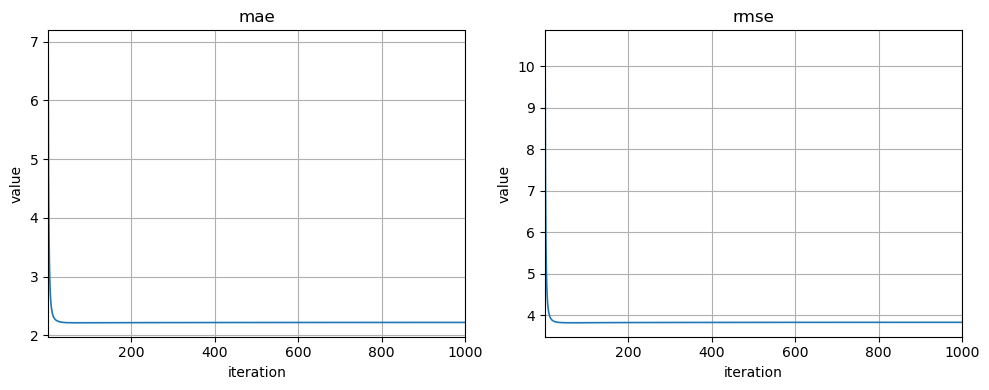

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
x = np.arange(1, len(mae) + 1)
axes[0].plot(x, mae, linewidth=1.2)
axes[0].set_title("mae")
axes[0].grid(True)
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("value")
axes[0].set_xlim(1, len(x))

axes[1].plot(x, rmse, linewidth=1.2)
axes[1].set_title("rmse")
axes[1].grid(True)
axes[1].set_xlabel("iteration")
axes[1].set_ylabel("value")
axes[1].set_xlim(1, len(x))

plt.show()